# Notebook with initial cleaning and filtering of the data

In this notebook we load the data and do basic cleaning by excluding all the quotations in which the main speaker is None. Then we load the Wikidata set with speaker attributes and try data augmentation. Finally, for each year we filter quotations in which the speakers are either from Republican or Democratic party.

## Installing and importing dependencies, mounting to drive

In [1]:
!pip install pyarrow
!pip install Wikidata
!pip install google.drive

     |████████████████████████████████| 57 kB 1.7 MB/s 
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.0.4
    Uninstalling google-auth-httplib2-0.0.4:
      Successfully uninstalled google-auth-httplib2-0.0.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.288 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is inc

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import json
import csv
import os
import bz2
import itertools 

from google.colab import drive
drive.mount('/content/drive')

from wikidata.client import Client
WIKI_CLIENT = Client()

Mounted at /content/drive


## Load Quotebank and discard 'None' speakers

First, we want to load the Quotebank dataset (years 2015 - 2020) and discard 
all the quotes for which the most probable speaker is unidentified ('None').

We save the resulting quotes into files whose names are formatted as 'quotes-no-nones-{year}.json.bz2'

In [ ]:
# Iterate through the years of existing Quotebank files
for year in range(2015, 2021):

  path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2' 
  path_to_out = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-no-nones-{year}.json.bz2'

  # If the output file for the current year already exists, skip it
  if os.path.isfile(path_to_out):
    print(f'\nFile for year {year} already exists. Moving on...')
    continue

  print(f'\nExtracting non-None quotations for year {year}')

  # Iterate through the quotes
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:

        # loading a sample and checking the speaker
        instance = json.loads(instance) 
        if instance['speaker'] == 'None':
          continue

        # writing in the new file
        d_file.write((json.dumps(instance)+'\n').encode('utf-8')) 


File for year 2015 already exists. Moving on...

File for year 2016 already exists. Moving on...

File for year 2017 already exists. Moving on...

File for year 2018 already exists. Moving on...

File for year 2019 already exists. Moving on...

File for year 2020 already exists. Moving on...


## Speaker attributes parquet

In [4]:
# Load the provided parquet file with information (QIDs) about each of the speakers
parquet_path = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'
speakers_attributes = pd.read_parquet(parquet_path)

In [ ]:
speakers_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


## Enriching Quotebank using Wikidata
We leverage the fact that we can easily enrich the Quotebank dataset by incorporating Wikidata into it. This is done by identifying the QID of the speaker (for a given quote), and then referring to the provided .parquet file with per-speaker information. 

The following columns are added to each quote information:    
* age
* nationality
* party
* academic degree
* ethnicity
* gender

NOTE - before doing that, we have to adopt a way to disambiguate the relation between speaker names and their corresponding QIDs (since there can be multiple QIDs mapped to a single speaker name). The method that we adopted is taking the QID with the smallest number, implying that it was created the earliest. There are also other heuristics that could be used, but we stuck with this one throughout the process.

### Wikidata API

Here, we used the Wikidata API to get the desired QID-label mappings. However, in the meantime, ADA staff provided us with a big .csv file with all these human-interpretable labels, so we will move to that approach when working on Milestone 3. Anyways, we are showing this, since we implemented it before getting the files from TAs, it would be a waste otherwise. :)

In [ ]:
def get_min_qid(qids):
  """
  Returns the QID with the smallest integer part.
  """
  qids_int = [int(qid.replace('Q', '')) for qid in qids]
  return f'Q{min(qids_int)}'


def map_qids_to_labels(qids, wiki_client=WIKI_CLIENT):
  """
  Given a set or list of QIDs, return a dictionary of format: {QID: label}
  We get the labels for each QID using the Wikidata client.
  """
  qids_labels_dict = dict()
  for qid in qids:
    try:
      # Multilingual to basic string
      qids_labels_dict[qid] = str(wiki_client.get(qid, load=True).label)
    except Exception:
      # In case the QID doesn't exist on Wikidata
      print(f'Problem with {qid}. Skipping...')

  return qids_labels_dict 


def add_wikidata_column_to_quote(
    quote_data_original, 
    column_name, 
    speakers_attributes,
    inplace=False,
    ignore_existing=True,
    is_qid=True
    ):
  """
  This functions takes as input a dictionary corresponding to a single quote 
  (with all the information that goes with it - 'speaker', 'qids', ...),
  a column name that we wish to add to the quote, depending on its speaker,
  and attributes for all speakers.
  It finds the speaker QID, accesses its attributes, and either takes the raw 
  values from the desired column (is_qid==False), or queries those QIDs and
  takes the corresponding human-interpretable labels (is_qid==True).
  """
  if inplace:
    quote_data = quote_data_original
  else:
    quote_data = quote_data_original.copy()

  # If we're not OK with overwriting the existing column, raise an exception
  if not ignore_existing:
    if column_name in quote_data:
      raise Exception(f'Provided column name "{column_name}" already exists!')

  # Raise an exception if the column name doesn't exist in speaker attributes
  if not column_name in speakers_attributes.columns:
    err_msg = f'Provided column name "{column_name}" does not exist in the '
    err_msg += 'provided speaker atttributes DataFrame!'
    raise Exception(err_msg)

  quote_data[column_name] = []

  # Get the 'correct' speaker QID and the corresponding speaker attributes
  speaker_qid = get_min_qid(quote_data['qids'])
  curr_speaker_attributes = speakers_attributes[
    speakers_attributes['id'] == speaker_qid
    ]

  # None check
  if curr_speaker_attributes[column_name].values[0] is None:
    return quote_data

  # If the column value is expected to be QID, query it using Wikidata API
  # If not, just take the raw values
  if is_qid:
    labels = map_qids_to_labels(
        curr_speaker_attributes[column_name].values[0].tolist()
        )
  else:
    labels_list = curr_speaker_attributes[column_name].values[0].tolist()
    labels = {i: val for i, val in enumerate(labels_list)}
  
  # Assign the labels to the new column
  for qid in labels:
    quote_data[column_name].append(labels[qid])

  return quote_data 



### Example of enriching the data
We provide a small example to demonstrate our Wikidata-enriching functions, to add the desired speaker attributes mentioned above. We divide them into columns that are represented as QIDs (needs querying) and that are not (does not need querying).

In [ ]:
# Define the columns that we want to add to the existing data
QID_COLUMNS_TO_ADD = [
  'nationality', 'party', 'ethnic_group', 'academic_degree', 'gender'
  ]
NON_QID_COLUMNS_TO_ADD = ['date_of_birth']

# Number of instances to process in this example
SAMPLES_TO_PROCESS = 10

year = 2019
path_to_file = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-no-nones-{year}.json.bz2'
running_df = pd.DataFrame()

# Iterate through the quotes
with bz2.open(path_to_file, 'rb') as s_file:
  for i, instance in enumerate(s_file):
    # Loading a sample and checking the speaker
    instance = json.loads(instance) 

    # Add the columns that require querying with Wikidata API
    for column_to_add in QID_COLUMNS_TO_ADD:
      add_wikidata_column_to_quote(
        instance, column_to_add, speakers_attributes, inplace=True
        )
    
    # Add the columns that don't require querying
    for column_to_add in NON_QID_COLUMNS_TO_ADD:
      add_wikidata_column_to_quote(
        instance, column_to_add, speakers_attributes, inplace=True, is_qid=False
        )
    
    # Append the current instance to the running data frame
    curr_df = pd.DataFrame([{k: str(v) for k, v in instance.items()}])
    running_df = pd.concat([running_df, curr_df])

    if i == SAMPLES_TO_PROCESS:
      break 

running_df.head(SAMPLES_TO_PROCESS)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,nationality,party,ethnic_group,academic_degree,gender,date_of_birth
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,President Donald Trump,['Q22686'],2019-04-08 16:22:00,44,"[['President Donald Trump', '0.5802'], ['None'...",['https://www.mercedsunstar.com/news/business/...,E,['United States of America'],"['Republican Party', 'Independence Party of Am...",[],['Bachelor of Science'],['male'],['+1946-06-14T00:00:00Z']
0,2019-05-15-053302,It is important for our equine science student...,Sally Johnson,['Q42336656'],2019-05-15 18:03:22,1,"[['Sally Johnson', '0.5721'], ['None', '0.4279']]",['https://www.lanereport.com/113381/2019/05/qu...,E,['United States of America'],[],[],[],['female'],[]
0,2019-02-27-055406,It is important to many Native American tribes...,Rafael Ortega,"['Q16672061', 'Q3417253', 'Q3417255', 'Q484101...",2019-02-27 00:00:00,1,"[['Rafael Ortega', '0.7587'], ['None', '0.2413']]",['http://kstp.com/news/riverview-corridor-proj...,E,['Venezuela'],[],[],[],['male'],['+1991-05-15T00:00:00Z']
0,2019-12-08-023053,"It is impossible, biologically, truly to `rest...",Barry Lopez,['Q809063'],2019-12-08 06:00:00,1,"[['Barry Lopez', '0.8142'], ['None', '0.1858']]",['https://www.timescolonist.com/opinion/op-ed/...,E,['United States of America'],[],[],[],['male'],['+1945-01-06T00:00:00Z']
0,2019-02-21-000088,[ Chilton ] put it on a little tape recorder a...,Sam the Sham,['Q1971786'],2019-02-21 11:05:34,1,"[['Sam the Sham', '0.6472'], ['None', '0.3278'...",['http://www.nashvillescene.com/music/features...,E,['United States of America'],[],[],[],['male'],['+1937-02-28T00:00:00Z']
0,2019-02-28-000093,... Darren just kind of kept fighting for me t...,Darren Lynn Bousman,['Q518770'],2019-02-28 04:00:57,1,"[['Darren Lynn Bousman', '0.4538'], ['None', '...",['http://filmthreat.com/interviews/actors-sabr...,E,['United States of America'],[],[],[],['male'],['+1979-01-11T00:00:00Z']
0,2019-02-01-053787,It is indisputable that we don't have years to...,Peter Boyles,['Q7172917'],2019-02-01 16:07:34,1,"[['Peter Boyles', '0.5464'], ['None', '0.3803'...",['https://ottawasun.com/news/local-news/corone...,E,['United States of America'],[],[],[],['male'],['+1943-10-17T00:00:00Z']
0,2019-06-18-000103,' DNA for property' is a special forensic adhe...,Amy Reid,['Q36427'],2019-06-18 03:12:14,1,"[['Amy Reid', '0.5782'], ['None', '0.4218']]",['http://www.channel3000.com/news/dodge-county...,E,['United States of America'],[],[],[],['female'],['+1985-04-15T00:00:00Z']
0,2019-07-29-031592,It is just the ongoing hardening of the Brexit...,John Hardy,"['Q18719463', 'Q23688353', 'Q2735767', 'Q53953...",2019-07-29 08:28:00,7,"[['John Hardy', '0.7852'], ['None', '0.1985'],...",['https://www.cnbc.com/2019/07/29/reuters-amer...,E,['Canada'],[],[],[],['male'],['+1941-07-09T00:00:00Z']
0,2019-10-30-000114,[ Donaton's ] creative instincts and strategic...,Kelly Campbell,['Q6385969'],2019-10-30 16:38:39,1,"[['Kelly Campbell', '0.6312'], ['None', '0.368...",['https://www.tubefilter.com/2019/10/30/digita...,E,['United States of America'],[],[],[],['male'],['+1980-07-23T00:00:00Z']


# Filtering data based on political party

This is initail preprocessing of the data. First we find what are the qids for Democrat and Republican party. Then we iterate dataset from Wikidata to form sets of quids from all democrates and republicans. Finally, for each year we make files that consists only of quotations from people in Democrat and Republican party.

In [6]:
# Defining qids of republican and democratic party
republican_qid = 'Q29468'
democratic_qid = 'Q29552'

democrates = set()
republicans = set()

# Making sets of qids from all republicans and democrates
for ind, row in speakers_attributes[['id','party']].iterrows():
  if np.any(row['party'] == democratic_qid):
    democrates.add(row['id'])
  if np.any(row['party'] == republican_qid):
    republicans.add(row['id'])

In [7]:
# Iterate through the years of existing Quotebank files (without nones) and extracting democrates and republicans
for year in range(2015, 2021):

  path_to_file = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-no-nones-{year}.json.bz2'
  path_to_republicans = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-republicans-{year}.json.bz2'
  path_to_democrates = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-democrates-{year}.json.bz2'

  # If the output file for the current year already exists, skip it
  if os.path.isfile(path_to_republicans) and os.path.isfile(path_to_democrates):
    print(f'\nFile for year {year} already exists. Moving on...')
    continue

  print(f'\nExtracting quotations for year {year} depending on the political party')

  dem_file = bz2.open(path_to_democrates, 'wb')
  rep_file = bz2.open(path_to_republicans, 'wb')

  with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
      # loading a sample
      instance = json.loads(instance) 

      # we suppose that the qid with minimal value is the correct one
      speaker_qid = get_min_qid(instance['qids'])
      
      # checking if the speaker is democrate
      if speaker_qid in democrates:
        dem_file.write((json.dumps(instance)+'\n').encode('utf-8'))

      # checking if the speaker is republican
      if speaker_qid in republicans:
        rep_file.write((json.dumps(instance)+'\n').encode('utf-8'))

  dem_file.close()
  rep_file.close()
     


File for year 2015 already exists. Moving on...

File for year 2016 already exists. Moving on...

File for year 2017 already exists. Moving on...

File for year 2018 already exists. Moving on...

File for year 2019 already exists. Moving on...

File for year 2020 already exists. Moving on...


# Basic descriptive data analysis

In [31]:
# Go through the bz2 file and count the number of objects
def count_number_of_quotes(s_file):
  cnt = 0
  for instance in s_file:
      cnt += 1
  return cnt

In [22]:
counts = {'republicans' : [], 'democrates' : []}

# Find the counts of members of both parties per year
for year in range(2015, 2021):
  path_to_republicans = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-republicans-{year}.json.bz2'
  path_to_democrates = f'/content/drive/MyDrive/Quotebank_limunADA/quotes-democrates-{year}.json.bz2'
  
  # Count the numbers of rows (quotes) in extracted files
  with bz2.open(path_to_republicans, 'rb') as s_file:
    counts['republicans'].append((year, count_number_of_quotes(s_file)))

  with bz2.open(path_to_democrates, 'rb') as s_file:
    counts['democrates'].append((year, count_number_of_quotes(s_file)))

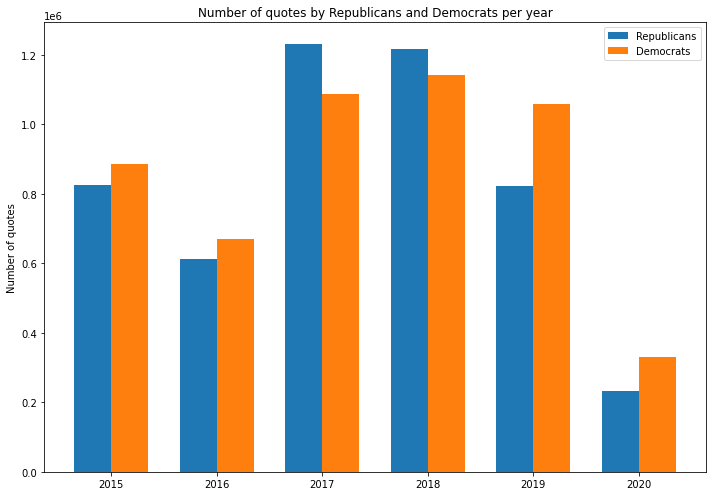

In [33]:
# Plot the results as a bar chart

labels = list(range(2015, 2021))

republicans_cnt_per_year = [t[1] for t in counts['republicans']]
democrats_cnt_per_year = [t[1] for t in counts['democrates']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, republicans_cnt_per_year, width, label='Republicans')
rects2 = ax.bar(x + width/2, democrats_cnt_per_year, width, label='Democrats')

ax.set_ylabel('Number of quotes')
ax.set_title('Number of quotes by Republicans and Democrats per year')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
fig.tight_layout()
plt.show()

Considering the abundance of quotations from both the members of Republican and Democrates parties (half a milion to more than a milion quotations per year), we can conclude that there is enough data to work with and move forward.

In [41]:
# Count mentions of certain word in all of the quotes of the file
def count_mentions(s_file, words):
  counts = {word : 0 for word in words}
  for instance in s_file:
      instance = json.loads(instance)
      for word in words:
        if word.lower() in instance['quotation'].lower():
          counts[word]+=1
          
  return counts

In [40]:
year = 2019
mentioned = ['immigration', 'racism', 'inequality']
with bz2.open(f'/content/drive/MyDrive/Quotebank_limunADA/quotes-republicans-{year}.json.bz2', 'rb') as s_file:
    counted_mentions_republicans = count_mentions(s_file, mentioned)

with bz2.open(f'/content/drive/MyDrive/Quotebank_limunADA/quotes-democrates-{year}.json.bz2', 'rb') as s_file:
    counted_mentions_democrates = count_mentions(s_file, mentioned)

In [44]:
print('Mentions of certain words by republicans in 2019\n', counted_mentions_republicans)
print('Mentions of certain words by democrates in 2019\n', counted_mentions_democrates)

Mentions of certain words by republicans in 2019
 {'immigration': 3425, 'racism': 842, 'inequality': 114}
Mentions of certain words by democrates in 2019
 {'immigration': 3979, 'racism': 2445, 'inequality': 886}
